<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

# Traitement Automatique de la Langue

## Tâche 1 : détection d'auteur, Chirac/Miterrand

_Import de librairies_

In [137]:
import codecs
import re
import string
from wordcloud import WordCloud
import time
import unicodedata
import numpy as np

import spacy
nlp = spacy.load("fr_core_news_sm")

import sklearn
import sklearn.naive_bayes as bayes
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import svm, linear_model as lin
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import FrenchStemmer

_Liens utiles_

##### Chargement des données
- http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3bow

##### Nettoyage, analyse des données textuelles
- https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4854971-nettoyez-et-normalisez-les-donnees
    
    

##### Méthodes utiles

In [3]:
def read_file(fn):
    with codecs.open(fn,encoding="utf-8") as f:
        return f.read()

In [4]:
def compteLignes(fname):
    count = 0
    with open(fname, 'r') as f:
        for line in f:
            count += 1
    return count

In [5]:
fname_train = "data/corpus.tache1.learn.utf8"
fname_test = "data/corpus.tache1.test.utf8"
file_train = codecs.open(fname_train,"r",encoding="utf-8")
file_test = codecs.open(fname_test,"r",encoding="utf-8")

In [6]:
n_train = compteLignes(fname_train)
n_test = compteLignes(fname_test)
print("Nombre de lignes pour le corpus de train = %d"%n_train)
print("Nombre de lignes pour le corpus de test = %d"%n_test)

Nombre de lignes pour le corpus de train = 57413
Nombre de lignes pour le corpus de test = 27162


In [9]:
def extract_labels_txt(corpus,n_lines):
    alltxts = []
    labels = np.ones(n_lines)
    
    for i in range(n_lines):
        line = corpus.readline()

        label = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",line)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",line)

        if label.count('M') > 0:
            labels[i] = -1
        
        alltxts.append(txt)

    return labels,alltxts

In [10]:
labels_train, corpus_train = extract_labels_txt(file_train,n_train)
labels_test, corpus_test = extract_labels_txt(file_test,n_test)

In [14]:
txt = corpus_train[500]
print(txt)
print("-----")
print("NOMBRE DE TOKENS = ",len(txt.split()))

 L'augmentation de nos échanges s'est considérablement accélérée depuis deux ans, et notamment depuis la visite du <nom> en France.

-----
NOMBRE DE TOKENS =  19


#### [ETAPE 1] Text Normalization/Cleaning

In [49]:
def text_normalization(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = string.punctuation
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub('\d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)
    # elimination des espaces au debut et à la fin
    s = s.strip()
    # texte en minuscule
    s = s.lower()

    return s

In [50]:
step_1 = text_normalization(txt)
print(step_1)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_1.split()))

l augmentation de nos échanges s est considérablement accélérée depuis deux ans et notamment depuis la visite du nom en france
-----
NOMBRE DE TOKENS =  21


#### POS Tagging

In [51]:
def postagging(s):
    print([w.pos_ for w in nlp(s)])
    print([w.text for w in nlp(s)])

In [52]:
postagging(step_2)

['ADP', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'AUX', 'ADV', 'VERB', 'ADP', 'NUM', 'NOUN', 'CCONJ', 'ADV', 'ADP', 'DET', 'NOUN', 'DET', 'NOUN', 'ADP', 'PROPN']
['l', 'augmentation', 'de', 'nos', 'échanges', 's', 'est', 'considérablement', 'accélérée', 'depuis', 'deux', 'ans', 'et', 'notamment', 'depuis', 'la', 'visite', 'du', 'nom', 'en', 'france']


#### [ETAPE 2] Suppresion des Stopwords

In [53]:
def delete_stopwords(s,stopwords) :
    tokens = nlp(s)
    return " ".join([w.text for w in tokens if w.text not in stopwords])

In [54]:
stopwords_fr = read_file("data/stopwords_french.txt").split("\r\n")
print("Liste des "+str(len(stopwords_fr))+" stopwords français :\n",stopwords_fr)

Liste des 691 stopwords français :
 ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 'aucun', 'aucune', 'aucuns', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autant', 'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'b', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'bon', 'boum', 'bravo', 'brrr', 'c', 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 'celui', 'celui-ci', 'celui-là', 'celà', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 

In [55]:
step_2 = delete_stopwords(step_1, stopwords_fr)
print(step_2)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_2.split()))

augmentation échanges considérablement accélérée ans visite nom france
-----
NOMBRE DE TOKENS =  8


#### [ETAPE 3] Stemmatisation

In [56]:
def stemmatisation(s) :
    stemmer = FrenchStemmer()
    words = []
    
    for w in s.split(" ") :
        if w != "" :
            words.append(stemmer.stem(w))
    
    new_s = ' '.join(words)

    
    return new_s

In [57]:
step_3 = stemmatisation(step_2)
print(step_3)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_3.split()))

augment échang consider accéler an visit nom franc
-----
NOMBRE DE TOKENS =  8


#### Pipeline du preprocessing

In [58]:
def preprocessing(s, option1, stopwords):
    if option1 == "stema" :
        if stopwords :
            return stemmatisation(delete_stopwords(text_normalization(s),stopwords))
        else :
            return stemmatisation(text_normalization(s))
    else :
        if stopwords :
            return delete_stopwords(text_normalization(s),stopwords)
        else :
            return text_normalization(s)

### Exploration et analyse de la matrice Document-Term

#### Construction des différents corpus

In [62]:
# On garde les stopwords
corpus_ = [preprocessing(d,"none",None) for d in corpus_train]
corpus_stema = [preprocessing(d,"stema",None) for d in corpus_train]
# On supprime les stopwords
corpus_sw = [preprocessing(d,"none",stopwords_fr) for d in corpus_train]
corpus_sw_stema = [preprocessing(d,"stema",stopwords_fr) for d in corpus_train]

all_corpus = [[corpus_, corpus_stema],
              [corpus_sw, corpus_sw_stema]]

#### [ETAPE 4] CountVectorizer

*max_df* is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

*min_df* is used for removing terms that appear too infrequently. For example:

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

![Représentation en une matrice sparse](img/sparse_matrix_corpus.png)

In [129]:
vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001)
X = vectorizer.fit_transform(corpus_sw_stema)

In [130]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("30 mots du vocabulaire : ", vocab[3000:3030])

Nombre de mots dans le vocabulaire :  5176
30 mots du vocabulaire :  ['mutual' 'mutuel' 'my' 'myster' 'mystéri' 'myth' 'mènent' 'mécan' 'mécen'
 'méconnaiss' 'méconnaîtr' 'méconnu' 'mécénat' 'médaill' 'médecin' 'médi'
 'médiat' 'médiateur' 'médic' 'médical' 'médit' 'méditerran'
 'méditerranéen' 'méfianc' 'mélancol' 'mélang' 'mémoir' 'mémorandum'
 'mémorial' 'ménag']


Text(0.5, 1.0, 'les 20 mots les moins fréquents')

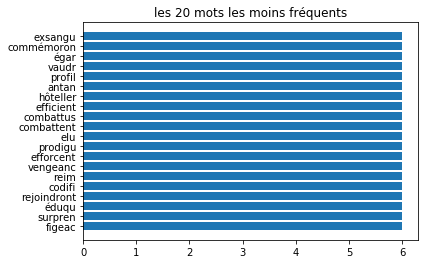

In [118]:
tf = X.toarray().sum(0)
n = 20
ind = tf.argsort()[:n]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

Text(0.5, 1.0, 'les 20 mots les plus fréquents')

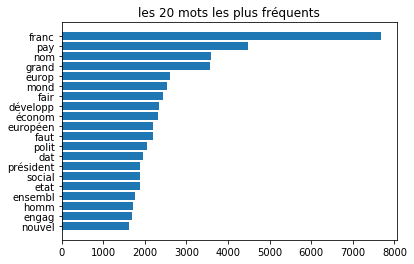

In [119]:
ind = tf.argsort()[-n:]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

**WordCloud : Les 10 mots les plus utilisés par président**

In [120]:
def generate_wordcloud(words, president) : 
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.title("Les 15 mots les plus utilisés par "+president)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [121]:
ind_C = np.where(labels_train == 1)
ind_M = np.where(labels_train == -1)

tf_C = X.toarray()[ind_C][:].sum(0)
tf_M = X.toarray()[ind_M][:].sum(0)

ind_mots_C = tf_C.argsort()[-15:]
ind_mots_M = tf_M.argsort()[-15:]

mots_C = vocab[ind_mots_C]
mots_M = vocab[ind_mots_M]

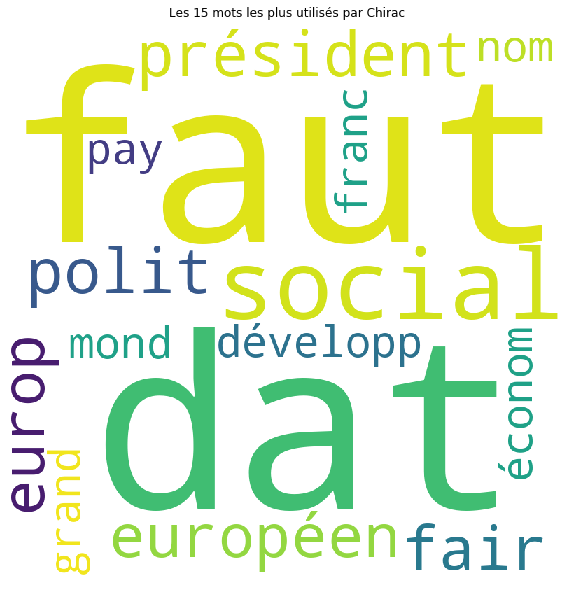

In [122]:
generate_wordcloud(" ".join(mots_C), "Chirac")

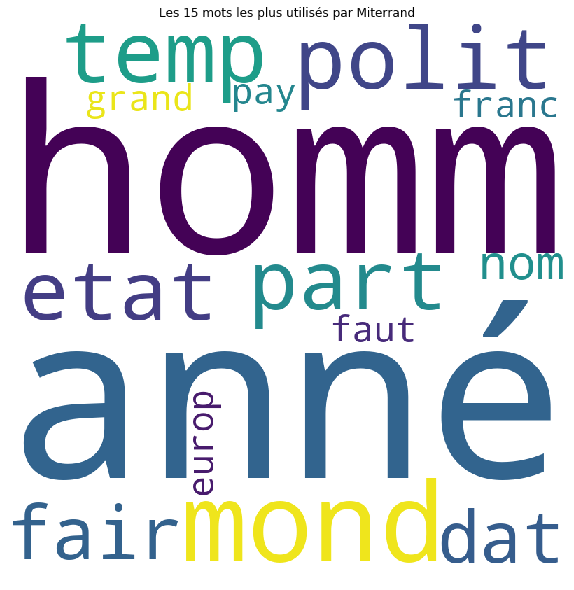

In [123]:
generate_wordcloud(" ".join(mots_M),"Miterrand")

### Optimisation des hyper-paramètres des modèles

In [142]:
def findBestHyperParam(name_clf, X_train, y_train,):
    if name_clf == "[reg_logistic]" :
        
        logistic = lin.LogisticRegression()

        param_grid = {'penalty':['l1', 'l2'],
                      'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                      'solver':['liblinear', 'saga']}

        grid = GridSearchCV(estimator=logistic,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)

        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    
    elif name_clf == "[bayes]" :
        
        multi_nb = bayes.MultinomialNB()
        
        param_grid = {'alpha': [0,0.1,1,10,100]}
        
        grid = GridSearchCV(estimator=multi_nb,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
        
    elif name_clf == "[svm]" :
        
        svc = svm.SVC()
        
        param_grid = {'C': [0.1,1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
        
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    else :
        print("Le nom du modèle ne comvient pas pour cette fonction !")

In [140]:
best_multinb = findBestHyperParam("[bayes]", X, labels_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.9299035390353548
Best Params:  {'alpha': 100}


[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


In [143]:
best_svm = findBestHyperParam("[svm]", X, labels_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
best_reg_logistic = findBestHyperParam("[reg_logistic]", X, labels)

## Campagne d'évaluation et comparaison de 3 modèles de classification

Cette campagne d'évaluation va consister à choisir les meilleurs paramètres pour déterminer la classe d'un avis.

Les paramètres qui seront modulés :
- avec ou sans Stopwords
- Unigram/Bigram/Trigram
- Stemmatisation

In [46]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(8)]
    abscissas = [[] for i in range(8)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram),max_df=0.85, min_df=0.0001)
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF', 
              'TF-STEMA','TFIDF-STEMA',
              'TF-STPW','TFIDF-STPW',
              'TF-STPW-STEMA','TFIDF-STPW-STEMA']
    
    for j in range(8) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - F1-score en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("F1-score")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(8)] 

    for _ in range(8):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

In [13]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(f1_score(y_test,clf.predict(X_test)))
        
    return sum(scores)/n_splits

In [14]:
def get_len_vocab(corpus, ngram):
    vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001, ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

In [17]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

#### 1-SVM

UNIGRAM

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

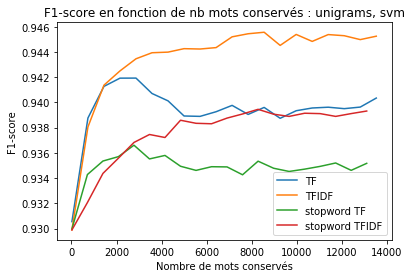

Temps d'éxécution : 1342.68 secondes
Meilleur score pour TF avec 2864 unigrams
Meilleur score pour TF-IDF avec 8552 unigrams
Meilleur score pour TF sans stopwords avec 2774 unigrams
Meilleur score pour TF-IDF sans stopwords avec 8283 unigrams


In [27]:
svm1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[SVM]")

BIGRAM

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

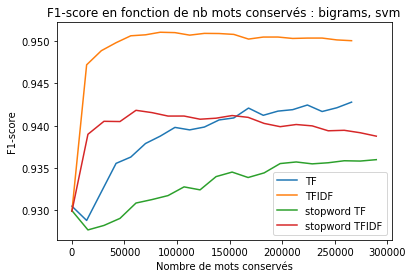

Temps d'éxécution : 1104.35 secondes
Meilleur score pour TF avec 265838 bigrams
Meilleur score pour TF-IDF avec 83962 bigrams
Meilleur score pour TF sans stopwords avec 289339 bigrams
Meilleur score pour TF-IDF sans stopwords avec 60929 bigrams


In [28]:
svm2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[SVM]")

#### 2- Naive Bayes

UNIGRAM

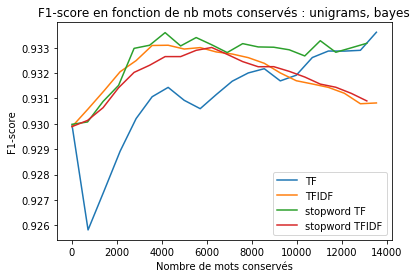

Temps d'éxécution : 94.1 secondes
Meilleur score pour TF avec 13529 unigrams
Meilleur score pour TF-IDF avec 4286 unigrams
Meilleur score pour TF sans stopwords avec 4151 unigrams
Meilleur score pour TF-IDF sans stopwords avec 6217 unigrams


In [29]:
bayes1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[MultiNBayes]")

BIGRAM

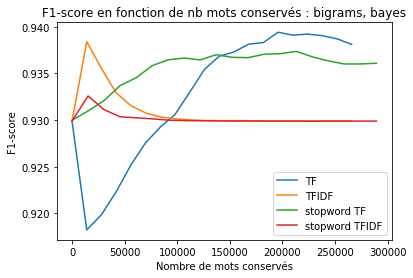

Temps d'éxécution : 232.16 secondes
Meilleur score pour TF avec 195885 bigrams
Meilleur score pour TF-IDF avec 14010 bigrams
Meilleur score pour TF sans stopwords avec 213202 bigrams
Meilleur score pour TF-IDF sans stopwords avec 15247 bigrams


In [30]:
bayes2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[MultiNBayes]")

#### 3- Régression Logistique

UNIGRAM

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

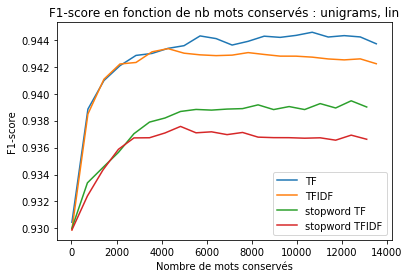

Temps d'éxécution : 287.64 secondes
Meilleur score pour TF avec 10685 unigrams
Meilleur score pour TF-IDF avec 4286 unigrams
Meilleur score pour TF sans stopwords avec 12415 unigrams
Meilleur score pour TF-IDF sans stopwords avec 4840 unigrams


In [31]:
lin1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[RegLogistic]")

BIGRAM

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dorian\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

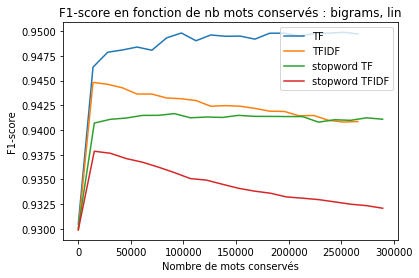

Temps d'éxécution : 1078.86 secondes
Meilleur score pour TF avec 251847 bigrams
Meilleur score pour TF-IDF avec 14010 bigrams
Meilleur score pour TF sans stopwords avec 91383 bigrams
Meilleur score pour TF-IDF sans stopwords avec 15247 bigrams


In [32]:
lin2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[RegLogistic]")

## Génération des prédictions pour le dataset de test

Selon la campagne d'évaluation, ...

In [15]:
def generate_file_test(predictions,nom_clf, tfidf, sw, ngram) :
    predict_letter = np.where(predictions == -1, 'M','C')
    
    filename = "predict_"+nom_clf+"_"+tfidf+"_"+sw+"_"+ngram+"gram"+".txt"
    
    with open(filename, "w") as f:
        for l in predict_letter :
            f.write("%s\n" % l)

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [54]:
"""best_clf = lin.LogisticRegression(max_iter = 1000)

best_vectorizer = CountVectorizer(max_features=lin2[2], ngram_range=(1,2))
X = best_vectorizer.fit_transform(corpus_train)
best_clf.fit(X,labels_train)

X_test = best_vectorizer.transform(corpus_test)
predictions = best_clf.predict(X_test)
generate_file_test(predictions,"reglog","tf","sw","bigram")"""

# Conclusion